In [1]:
import sys
sys.path.append("/home/debian/gabe/SO_Post_Analyzer")

In [2]:
import collections
import csv
import datetime
import itertools
import json
import tqdm
import random
import nltk
import numpy as np
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

import follow_up_projects.urn_model.polyas_urn_model as polyas_urn_model
import follow_up_projects.urn_model.multiurn_model as multiurn_model
from follow_up_projects.random_walk import random_walk as rw

In [3]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def get_wordnet_pos(treebank_tag):
    """Map NLTK POS tags to WordNet POS tags."""
    if treebank_tag.startswith('N'):
        return wordnet.NOUN
    return None


def extract_singular_nouns(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    
    lemmatizer = WordNetLemmatizer()
    
    singular_nouns = []
    for word, tag in tagged:
        wn_tag = get_wordnet_pos(tag)
        if wn_tag == wordnet.NOUN:
            singular_form = lemmatizer.lemmatize(word, pos=wn_tag)
            singular_nouns.append(singular_form)
    
    return singular_nouns

[nltk_data] Downloading package punkt to /home/debian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/debian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/debian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
titles = []
nouns = []
with open("data/BooksDatasetClean.csv") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in tqdm.tqdm(reader):
        published = datetime.datetime.strptime(
            f"{row['Publish Date (Year)']},{row['Publish Date (Month)']},1",
            "%Y,%B,%d").date()
        # initial filter&format
        lower_alphas = [w.lower().strip() for w in row['Title'].split() if w.isalpha()]
        extracted_nouns = extract_singular_nouns(" ".join(lower_alphas))
        assert len(extracted_nouns) <= len(lower_alphas)
        
        titles.append((published, lower_alphas))
        nouns.append((published, extracted_nouns))


103063it [00:43, 2347.65it/s]


In [5]:
sorted_nouns = sorted(nouns)
sorted_titles = sorted(titles)

In [6]:
with open("sorted_titles.json", "w") as handle:
    json.dump([t[1] for t in sorted_titles], handle)

In [7]:
import itertools
import matplotlib.pyplot as plt

word_have_seen = set()
word_counts = []

word_pair_have_seen = set()
word_pair_counts = []

noun_have_seen = set()
noun_counts = []

noun_pair_have_seen = set()
noun_pair_counts = []

for dt, words in sorted_titles:
    for word in words:
        word_have_seen.add(word)
    word_counts.append(len(word_have_seen))
    for combos in itertools.combinations(words, 2):
        canonical_name = "|".join(sorted(combos))
        word_pair_have_seen.add(canonical_name)
    word_pair_counts.append(len(word_pair_have_seen))

for dt, nouns in sorted_nouns:
    for noun in nouns:
        noun_have_seen.add(noun)
    noun_counts.append(len(noun_have_seen))
    for combos in itertools.combinations(nouns, 2):
        canonical_name = "|".join(sorted(combos))
        noun_pair_have_seen.add(canonical_name)
    noun_pair_counts.append(len(noun_pair_have_seen))

In [8]:
import json
with open("word_pair_have_seen.json", "w") as handle:
    json.dump(list(word_pair_have_seen), handle)

Fit took 0.12 seconds
Fit performed; alpha=0.5346620427394504 c=60.82142204147201


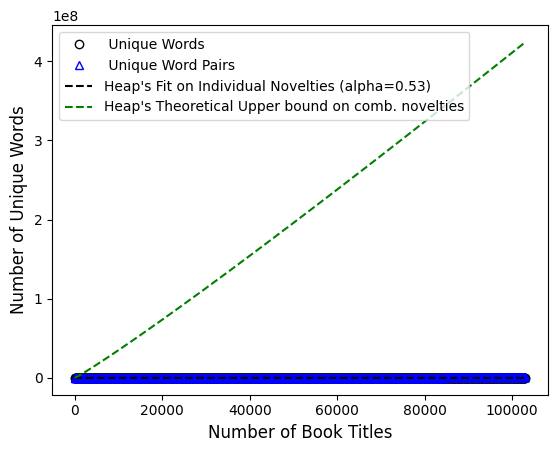

In [9]:
STEP_SIZE = 100

plt.plot(range(0, len(word_counts), STEP_SIZE), word_counts[::STEP_SIZE], "ko", label=" Unique Words", markerfacecolor='none')
plt.plot(range(0, len(word_pair_counts), STEP_SIZE), word_pair_counts[::STEP_SIZE], "b^", label=" Unique Word Pairs",  markerfacecolor='none')
#plt.plot(range(len(noun_counts)), noun_counts, "r-", label=" Unique Nouns")
#plt.plot(range(len(noun_pair_counts)), noun_pair_counts, "r--", label=" Unique Noun Pairs")
def format_with_commas(x):
    return '{:,}'.format(int(x))

plt.xlabel("Number of Book Titles", fontsize=12)
plt.ylabel("Number of Unique Words", fontsize=12)

# plt.xticks(ticks=list(range(0, 100_000, 20_000)),
#            labels=[format_with_commas(x) for x in range(0, 100_000, 20_000)],
#            fontsize=12, rotation=25)
# plt.yticks(ticks=list(range(0, 30_000, 5_000)),
#            labels=[format_with_commas(y) for y in range(0, 30_000, 5_000)],fontsize=12)

from sklearn.linear_model import LinearRegression
import time

t0 = time.time()
libs_count = word_counts
xs = np.array(range(1, len(libs_count)+1))
xs_transformed = np.log(xs).reshape(-1 ,1 )
counts_transformed = np.log(np.array(libs_count) + 1)

model = LinearRegression()
model.fit(xs_transformed, counts_transformed)

alpha = model.coef_[0]
log_c = model.intercept_
c = np.exp(log_c)
t1 = time.time()

print(f"Fit took {round(t1-t0, 2)} seconds")
print(f"Fit performed; alpha={alpha} c={c}")
plt.plot(xs, [c * x ** alpha for x in xs], "k--", label=f"Heap's Fit on Individual Novelties (alpha={round(alpha, 2)})")
plt.plot(xs, [(c * x ** alpha) * (c * x ** alpha - 1) / 2 for x in xs], "g--", label=f"Heap's Theoretical Upper bound on comb. novelties")
plt.legend()
#plt.loglog()


In [10]:
from sklearn.linear_model import LinearRegression

xs = np.array(range(1, len(word_counts)+1))
xs_transformed = np.log(xs).reshape(-1 ,1 )
counts_transformed = np.log(np.array(word_counts) + 1)

model = LinearRegression()
model.fit(xs_transformed, counts_transformed)

alpha = model.coef_[0]
log_c = model.intercept_
c = np.exp(log_c)


# Do the same fit for pairs
pairs_xs = np.array(range(1, len(word_pair_counts)+1))
pairs_xs_transformed = np.log(pairs_xs).reshape(-1 ,1 )
pairs_counts_transformed = np.log(np.array(word_pair_counts) + 1)

model = LinearRegression()
model.fit(pairs_xs_transformed, pairs_counts_transformed)

pairs_alpha = model.coef_[0]
pairs_log_c = model.intercept_
pairs_c = np.exp(pairs_log_c)



In [11]:
sorted_titles_lengths = [len(title[1]) for title in sorted_titles]

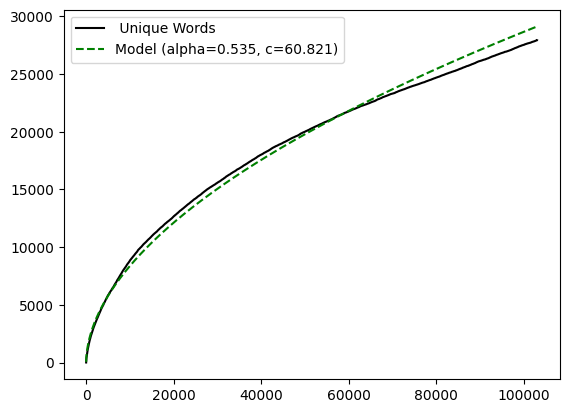

In [12]:
plt.plot(xs, word_counts, "k-", label=" Unique Words")
#plt.plot(xs, word_pair_counts, "k-", label=" Unique Word Pairs")

plt.plot(xs, [c * x ** alpha for x  in xs], "--", color='green', label=f"Model (alpha={round(alpha, 3)}, c={round(c, 3)})")
#plt.plot(xs, sim["element_counts"], "--", color='red', label=f"Sim (bps: {bps} nei: {nei} noi: {noi})")
#plt.plot(xs, sim["pairs_counts"], "k--",label=f"Sim (bps: {bps} nei: {nei} noi: {noi})")
#plt.plot(xs, word_pair_counts, "r-", label="Unique Pairs")
#plt.plot(xs, [pairs_c * x ** pairs_alpha for x  in xs], "--",
#         color='black', label=f"Pairs Model (alpha={round(pairs_alpha, 3)}, c={round(pairs_c, 3)})")


plt.legend()

In [13]:
import importlib
importlib.reload(polyas_urn_model)

bps = 400
nei = 500
noi = 800
sim = None
sim = polyas_urn_model.urn_simulation(
    rounds=len(titles), 
    base_pool_size=bps, 
    new_element_increment=nei, 
    new_opportunity_increment=noi, 
    card_sizes=sorted_titles_lengths,
    return_urns=False,
) 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103063/103063 [00:26<00:00, 3839.04it/s]


In [21]:
import importlib
importlib.reload(multiurn_model)

m_bpc = 100
m_bps = 4
m_nei = 500
m_noi = 800
swap_propability=1.0
multi_sim = None
multi_sim = multiurn_model.multi_urn_simulation(
    rounds=len(titles),
    base_pool_count=m_bpc,
    base_pool_size=m_bps,
    new_element_increment=m_nei,
    new_opportunity_increment=m_noi,
    swap_propability=swap_propability,
    card_sizes=sorted_titles_lengths,
    return_urns=False,
    ) 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103063/103063 [00:33<00:00, 3067.33it/s]


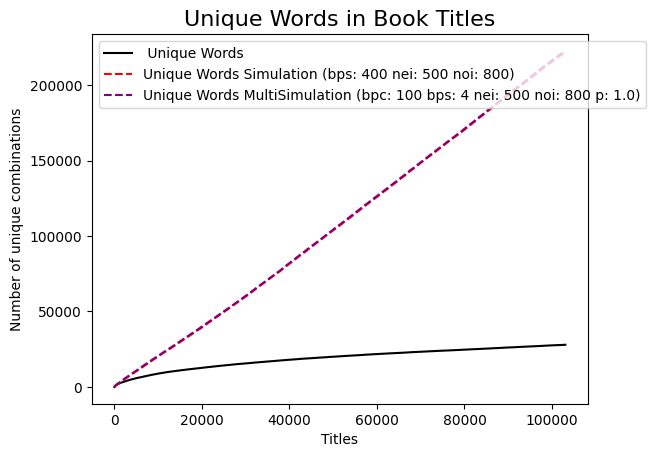

In [23]:
plt.plot(range(len(word_counts)), word_counts, "k-", label=" Unique Words")
plt.plot(range(len(sim["element_counts"])), sim["element_counts"], "--", color="red", label=f"Unique Words Simulation (bps: {bps} nei: {nei} noi: {noi})")
plt.plot(range(len(multi_sim["element_counts"])), multi_sim["element_counts"], "--", color="purple", label=f"Unique Words MultiSimulation (bpc: {m_bpc} bps: {m_bps} nei: {m_nei} noi: {m_noi} p: {swap_propability})")

plt.title("Unique Words in Book Titles", fontsize=16)
plt.xlabel("Titles")
plt.ylabel("Number of unique combinations")
plt.legend(loc='upper left')
#plt.xlim(0,20)
#plt.loglog()

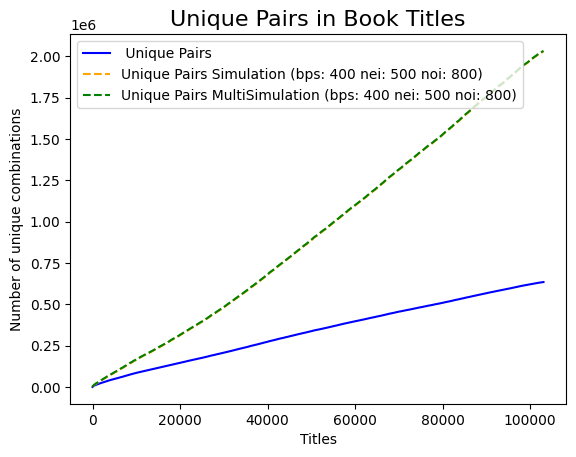

In [24]:
#plt.plot(xs, word_counts, "k-", label=" Unique Words")
plt.plot(range(len(word_pair_counts)), word_pair_counts, "b-", label=" Unique Pairs")

#plt.plot(xs, [c * x ** alpha for x  in xs], label=f"Model (alpha={round(alpha, 3)}, c={round(c, 3)})")
#plt.plot(xs, sim["element_counts"], "--", color="red", label=f"Unique Words Simulation (bps: {bps} nei: {nei} noi: {noi})")
plt.plot(range(len(sim["pairs_counts"])), sim["pairs_counts"], "--", color="orange", label=f"Unique Pairs Simulation (bps: {bps} nei: {nei} noi: {noi})")
plt.plot(range(len(multi_sim["pairs_counts"])), multi_sim["pairs_counts"], "--", color="green", label=f"Unique Pairs MultiSimulation (bps: {bps} nei: {nei} noi: {noi})")
plt.title("Unique Pairs in Book Titles", fontsize=16)
plt.xlabel("Titles")
plt.ylabel("Number of unique combinations")
plt.legend()
#plt.loglog()

In [17]:
len(word_pair_counts), len(sim["pairs_counts"])

(103063, 103063)

Text(0.5, 1.0, 'Urn model overshot ratio for book titles')

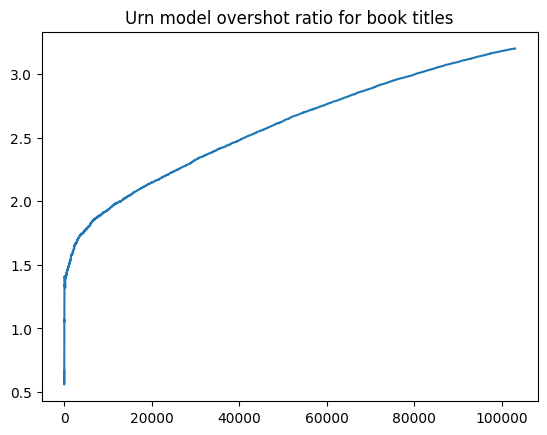

In [18]:
plt.plot(range(len(word_pair_counts)), np.array(sim["pairs_counts"])/ np.array(word_pair_counts))
plt.title("Urn model overshot ratio for book titles")

# Random Walk approach

In [19]:
edges = [item.split("|") for item in word_pair_have_seen]
word_graph = rw.create_graph(edges)
title_lengths = [len(title[1]) for title in sorted_titles]

walk = rw.random_walk(word_graph, sorted_titles[0][1][0], sum(title_lengths) - 1, 15)

  8%|█████████████▏                                                                                                                                                         | 46220/587641 [01:04<12:40, 711.61it/s]


KeyboardInterrupt: 

In [ ]:
walk_popable = collections.deque(walk)

In [ ]:
plt.figure()

xs = list(range(len(sim["pairs_counts"])))
plt.plot(xs, word_pair_counts, color="red", label=" Unique Word Pairs - Real Data")
plt.plot(xs, sim["pairs_counts"], "--", color="green", label=f"Unique Pairs Simulation (bps: {bps} nei: {nei} noi: {noi})")

for reinforcement in [0.1, 10]:

    edges = [item.split("|") for item in word_pair_have_seen]
    word_graph = rw.create_graph(edges)
    title_lengths = [len(title[1]) for title in sorted_titles]

    walk = rw.random_walk(word_graph, sorted_titles[0][1][0], sum(title_lengths) - 1, reinforcement)
    walk_popable = collections.deque(walk)

    words_have_seen = set()
    word_pairs_have_seen = set()
    unique_word_count = []
    unique_pair_count = []
    for title_length in tqdm.tqdm(title_lengths):
        card = [walk_popable.popleft() for _ in range(title_length)]
        for item in card:
            words_have_seen.add(item)
        for pair in itertools.combinations(card, 2):
            word_pairs_have_seen.add(pair)
        unique_word_count.append(len(words_have_seen))
        unique_pair_count.append(len(word_pairs_have_seen))
    plt.plot(xs, unique_pair_count, label=f"Unique Pairs - Walk (reinf: {reinforcement})")
plt.legend()

In [ ]:
plt.figure()
plt.plot(list(range(len(word_counts))), word_counts, color="black", label=" Unique Words - Real Data")
#plt.plot(list(range(len(word_pair_counts))), word_pair_counts, color="red", label=" Unique Word Pairs - Real Data")
#plt.plot(list(range(len(word_pair_counts))), sim["pairs_counts"], "--", color="green", label=f"Unique Pairs Simulation (bps: {bps} nei: {nei} noi: {noi})")

for r in [0.1]:
    with open(f"network_novelty_sim_r_{r}.json") as handle:
        data = json.load(handle)
        unique_word_count = data.get("unique_word_count")
        unique_pair_count = data.get("unique_pair_count")    
    plt.plot(xs, unique_word_count, label=f"Unique Words - Walk (r={r})")
    #plt.plot(xs, unique_pair_count,"-.", label=f"Unique Pairs - Walk (r={r})")
plt.legend()
plt.loglog()

In [ ]:
sorted_titles[0], sorted_titles[-1]

# Authors to Words

In [ ]:
import collections

author_to_words = collections.defaultdict(set)
author_to_books = collections.defaultdict(int)
no_alpha_title_count = 0 
with open("data/BooksDatasetClean.csv") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in tqdm.tqdm(reader):
        author = row['Authors']
        lower_alphas = [w.lower().strip() for w in row['Title'].split() if w.isalpha()]
        if not lower_alphas:
            no_alpha_title_count += 1
            continue
        for word in lower_alphas:
            author_to_words[author].add(word)
        author_to_books[author] += 1
print(f"Finished, encountered {no_alpha_title_count} non-alpha titles (skipped)")

author_to_word_count = {k: len(v) for k, v in author_to_words.items()}

In [ ]:
{k:v for k, v in author_to_books.items() if v > 500}

In [ ]:
print(len(sorted(author_to_books.keys())), len(sorted(author_to_words.keys())))

xs = [author_to_books[author] for author in sorted(author_to_books.keys())]
ys = [author_to_word_count[author] for author in sorted(author_to_word_count.keys())]
plt.xlabel("Number of Books Written by the author(s)")
plt.ylabel("Number of different words used by the author(s)")
plt.scatter(xs, ys, alpha=0.5)
plt.xlim(0,200)
plt.ylim(0, 500)

In [ ]:
import pandas as pd
import seaborn as sns

# Prepare the data for plotting
data = {
    'Author': list(author_to_books.keys()),
    'Books': [author_to_books[author] for author in author_to_books],
    'WordCount': [author_to_word_count[author] for author in author_to_word_count]
}

df = pd.DataFrame(data)

# Create logarithmic bins for the number of books
bins = np.logspace(0, np.log10(500), num=11)  # Log bins up to 500
labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]
df['BooksBin'] = pd.cut(df['Books'], bins=bins, labels=labels)

# Use sns.pointplot to visualize the binned data
plt.figure(figsize=(10, 6))
sns.pointplot(x='BooksBin', y='WordCount', data=df)
plt.xlabel("Number of Books Written (Log Binned)")
plt.ylabel("Number of Different Words Used")
plt.title("Number of Different Words Used by Authors Based on Number of Books Written (Log Binned)")
#plt.xlim(0, 500)
plt.ylim(0, 500)
plt.show()

In [ ]:
df['BooksBin']

In [ ]:
np.logspace(0, 3, num=5)

# Words Graphs

In [ ]:
edges = [item.split("|") for item in word_pair_have_seen]
nodes = set()
for a, b in edges:
    nodes.add(a)
    nodes.add(b)
nodes

In [ ]:
edge_weights = collections.defaultdict(int)
title_words = [item[1] for item in sorted_titles]
for title in tqdm.tqdm(title_words):
    for pair in itertools.combinations(title, 2):
        edge_weights[tuple(pair)] += 1

edges_triples = [(k[0], k[1], v) for k, v in edge_weights.items()]
edges_triples

In [ ]:
edge_weights

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()



# Add nodes
G.add_nodes_from(nodes)
print("Nodes added")
# Add weighted edges

# Adding edges to the graph with weights
for (u, v, w) in tqdm.tqdm(edges_triples):
    G.add_edge(u, v, weight=w)
print("Edges added")
# Compute the positions of the nodes using the spring layout
pos = nx.spring_layout(G, weight='weight', scale=2)

In [ ]:
# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=False, node_size=700, node_color='skyblue', font_weight='bold', font_size=15)